In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
pwd

'/home/yzerlaut/work/anesthPlot/tests'

In [3]:
cd ../src

/home/yzerlaut/work/anesthPlot/src


In [4]:
import wavelet_transform as wavelet

In [5]:
cd ..

/home/yzerlaut/work/anesthPlot


In [6]:
import record_main as recmain
import treatrec as treat
from treatrec import ekg_to_hr

added /home/yzerlaut/work/anesthPlot  to the path
location= /home/yzerlaut/work/anesthPlot


In [7]:
def load(tfile = 'M2020_2_4-9_49_5.csv',
         wfile = 'M2020_2_4-9_49_5Wave.csv',
         dir_loc = '~/enva/clinique/recordings/anesthRecords/onPanelPcRecorded'):
    
    #files:
    if os.path.isfile(tfile):
        trend_filename = tfile
    else:
        trend_filename = os.path.join(dir_loc, tfile)
        
    if os.path.isfile(wfile):
        wave_filename = wfile
    else:
        wave_filename = os.path.join(dir_loc, wfile)  
        
    #trends
    monitorTrend = recmain.MonitorTrend(trend_filename)
    params = recmain.build_param_dico(file=tfile, source='monitorTrend')
    #waves
    monitorWave = recmain.MonitorWave(wave_filename)
    params = recmain.build_param_dico(file=wfile, source='monitorWave')
    params['fs'] = float(monitorWave.header['Data Rate (ms)'])*60/1000
    params['kind'] = 'as3'
    monitorWave.param = params
    #remove unnecessary waves
    for item in ['wflow', 'wawp', 'wvp']:
        del monitorWave.data[item]
    return monitorTrend, monitorWave


In [8]:
monitorTrend, monitorWave = load(tfile='data/recordingTest/trend.csv',
                                 wfile='data/recordingTest/wave.csv')

loading  wave.csv


In [11]:
params = monitorWave.param
print(params)

{'item': 1, 'xmin': None, 'xmax': None, 'ymin': 0, 'ymax': None, 'path': '/home/yzerlaut/work/anesthPlot/data', 'unit': 'min', 'save': False, 'memo': False, 'file': 'data/recordingTest/wave.csv', 'source': 'monitorWave', 'fs': 300.0, 'kind': 'as3'}


In [10]:
ekg_df = pd.DataFrame(monitorWave.data.wekg)*(-1)

#low pass filtering
ekg_df['wekg_lowpass'] = recmain.wf.fix_baseline_wander(ekg_df.wekg,
                                                monitorWave.param['fs'])
# beats locations (beat based dataFrame)
beat_df = treat.ekg_to_hr.detect_beats(ekg_df.wekg_lowpass, params)
#plot
figure = treat.ekg_to_hr.plot_beats(ekg_df.wekg_lowpass, beat_df)

#fs=300
beat_df= treat.ekg_to_hr.compute_rr(beat_df, monitorWave.param)
hr_df = treat.ekg_to_hr.interpolate_rr(beat_df)


source = Python port of BaselineWanderRemovalMedian.m from ECG-kit
Alex Page, alex.page@rochester.edu
https://bitbucket.org/atpage/baselinewanderremoval/src/master/


In [16]:
plt.plot(beat_df.pLoc, beat_df.rr)

In [20]:
plt.plot(hr_df.rrInterpol)

In [13]:
dt = 1./300.
t, data = np.arange(len(hr_df.rrInterpol))*dt, np.array(hr_df.rrInterpol)
data = data-data.mean()
freqs = np.logspace(-3, 0, 20)
coefs = wavelet.my_cwt(data, freqs, dt)

In [14]:
ifreq, itime = 10, 10000
print("for freq %.2fHz, at time %.1fs, the wavelet coef is %s" % (freqs[ifreq], t[itime], coefs[ifreq, itime]))

for freq 0.04Hz, at time 33.3s, the wavelet coef is (61.26585345553567+147.33210487018638j)


In [15]:
t[-1]/60, len(data)

(96.11577777777778, 1730085)

In [16]:
monitorTrend.data.eTimeMin.max()

103.66666666666667

In [17]:
def time_freq_plot(t, freqs, data, coefs):
    """
    a plot to illustrate the output of the wavelet analysis
    """
    dt = t[1]-t[0]

    fig = plt.figure(figsize=(8,5))
    plt.subplots_adjust(wspace=.8, hspace=.5, bottom=.2)
    # signal plot
    plt.subplot2grid((3, 8), (0,0), colspan=6)
    plt.plot(t, data, 'k-', lw=2)
    plt.ylabel('signal')
    plt.xlim([t[0], t[-1]])
    # time frequency power plot
    ax1 = plt.subplot2grid((3, 8), (1,0), rowspan=2, colspan=6)
    c = plt.contourf(t, freqs, coefs, cmap='PRGn', aspect='auto')
    plt.xlabel('time (ms)')
    plt.ylabel('frequency (Hz)')
    plt.yscale('log')
    # inset with legend
    acb = plt.axes([.8, .7, .02, .2])
    plt.colorbar(c, cax=acb, label='coeffs (a.u.)', ticks=[-1, 0, 1])
    # mean power plot over intervals
    plt.subplot2grid((3, 8), (1, 6), rowspan=2)
    plt.barh(freqs, np.power(coefs,2).mean(axis=1)*dt)
    plt.xticks([]);
    plt.xlabel(' mean \n power \n (a.u.)')
    # max of power over intervals
    plt.subplot2grid((3, 8), (1, 7), rowspan=2)
    plt.barh(freqs, np.power(coefs,2).max(axis=1)*dt)
    plt.xticks([]);
    plt.xlabel(' max. \n power \n (a.u.)');
    return fig

In [18]:
1./0.001/60

16.666666666666668

In [19]:
time_freq_plot(t[::100], freqs, data[::100], coefs[:,::100]);

/home/yzerlaut/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:2788: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)
/home/yzerlaut/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'aspect'
  app.launch_new_instance()
/home/yzerlaut/anaconda3/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


In [68]:
monitorWave.data.sec[-1:]/60

1868540    103.807778
Name: sec, dtype: float64

In [23]:
monitorTrend, monitorWave = load(tfile='../data/recordingTest/trend.csv',
                                 wfile='../data/recordingTest/wave.csv')
ekg_df = pd.DataFrame(monitorWave.data.wekg)*(-1)l

loading  wave.csv


In [24]:
#low pass filtering
ekg_df['wekg_lowpass'] = recmain.wf.fix_baseline_wander(ekg_df.wekg,
                                                monitorWave.param['fs'])

source = Python port of BaselineWanderRemovalMedian.m from ECG-kit
Alex Page, alex.page@rochester.edu
https://bitbucket.org/atpage/baselinewanderremoval/src/master/


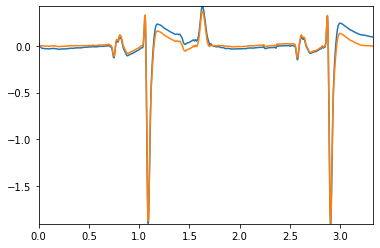

In [35]:
i0, n = 500000, 1000
dt = 1./300.
plt.plot(np.arange(n)*dt, ekg_df.wekg[i0:][:n])
plt.plot(np.arange(n)*dt, ekg_df['wekg_lowpass'][i0:][:n])

In [29]:
len(ekg_df), len(beat_df)

(1868541, 3239)

In [28]:
#fs=300
beat_df= treat.ekg_to_hr.compute_rr(beat_df, monitorWave.param)

In [57]:
i_rr = np.argmin((beat_df.pLoc-i0)**2)
beat_df.rr[i_rr]

1690.0

In [53]:
np.sum(beat_df.pLoc==i0-1)

0

In [77]:

#fs=300
beat_df= treat.ekg_to_hr.compute_rr(beat_df, monitorWave.param)
hr_df = treat.ekg_to_hr.interpolate_rr(beat_df)


In [30]:
len(hr_df)

1730085